## Maximum a Posteriori Introduction

In this notebook, we demonstrate an example of parameter estimation for a single-particle model using the AdamW optimiser [1][2]. The AdamW optimiser is an algorithm for gradient-based optimisation, combining the advantages of the Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp).

[[1]: Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980) 

[[2]: Decoupled Weight Decay Regularization](https://doi.org/10.48550/arXiv.1711.05101)

### Setting up the Environment

Before we begin, we need to ensure that we have all the necessary tools. We will install PyBOP and upgrade dependencies:

In [ ]:
%pip install --upgrade pip ipywidgets -q
%pip install pybop -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Importing Libraries

With the environment set up, we can now import PyBOP alongside other libraries we will need:

In [ ]:
import time

import numpy as np

import pybop

Let's fix the random seed in order to generate consistent output during development, although this does not need to be done in practice.

In [ ]:
np.random.seed(8)

### Generate Synthetic Data

To demonstrate parameter estimation, we first need some data. We will generate synthetic data using the PyBOP forward model, which requires defining a parameter set and the model itself.

#### Defining Parameters and Model

We start by creating an example parameter set and then instantiate the single-particle model (SPM):

In [ ]:
parameter_set = pybop.ParameterSet.pybamm("Chen2020")
# parameter_set.update(
#     {
#     "Positive electrode active material volume fraction": 0.6,
#     "Negative electrode active material volume fraction": 0.6,
#     }
# )
model = pybop.lithium_ion.SPM(parameter_set=parameter_set)

### Simulating Forward Model

We can then simulate the model using the `predict` method, with a default constant current to generate voltage data.

In [ ]:
n = 9
observations = [2**j for j in range(1, n + 1)]
values = []
for i in observations:
    t_eval = np.linspace(0, 10, i)
    values.append(model.predict(t_eval=t_eval))

### Adding Noise to Voltage Data

To make the parameter estimation more realistic, we add Gaussian noise to the data.

In [ ]:
sigma = 0.001
corrupt_values = values[1]["Voltage [V]"].data + np.random.normal(
    0, sigma, len(values[1]["Voltage [V]"].data)
)

## Identify the Parameters

We will now set up the parameter estimation process by defining the datasets for optimisation and selecting the model parameters we wish to estimate.

### Creating Optimisation Dataset

The dataset for optimisation is composed of time, current, and the noisy voltage data:

In [ ]:
dataset = pybop.Dataset(
    {
        "Time [s]": values[1]["Time [s]"].data,
        "Current function [A]": values[1]["Current [A]"].data,
        "Voltage [V]": corrupt_values,
    }
)

### Defining Parameters to Estimate

We select the parameters for estimation and set up their prior distributions and bounds:

In [ ]:
parameters = [
    pybop.Parameter(
        "Negative particle radius [m]",
        initial_value=3e-6,
        # bounds=[0.5, 0.8],
    ),
    pybop.Parameter(
        "Positive particle radius [m]",
        initial_value=3e-6,
        # bounds=[0.4, 0.7],
    ),
]

### Setting up the Optimisation Problem

With the datasets and parameters defined, we can set up the optimisation problem, its cost function, and the optimiser.

In [ ]:
problem = pybop.FittingProblem(model, parameters, dataset)
likelihood = pybop.GaussianLogLikelihoodKnownSigma(problem, sigma0=0.005)
prior = pybop.JointLogPrior(pybop.Gaussian(4e-6, 0.5e-6), pybop.Gaussian(4e-6, 0.5e-6))

cost = pybop.LogPosterior(likelihood, prior)

### Plotting the landscapes

Next, we plot the Log Posterior components individually. The `LogPosterior` class provides properties to interrogate the prior and likelihood. To investigate the contributions of each to the Posterior we plot the landscapes across a selected parameter range.

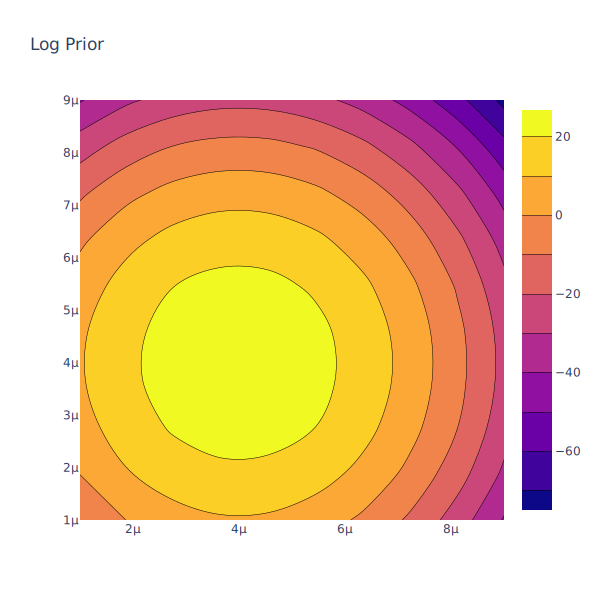

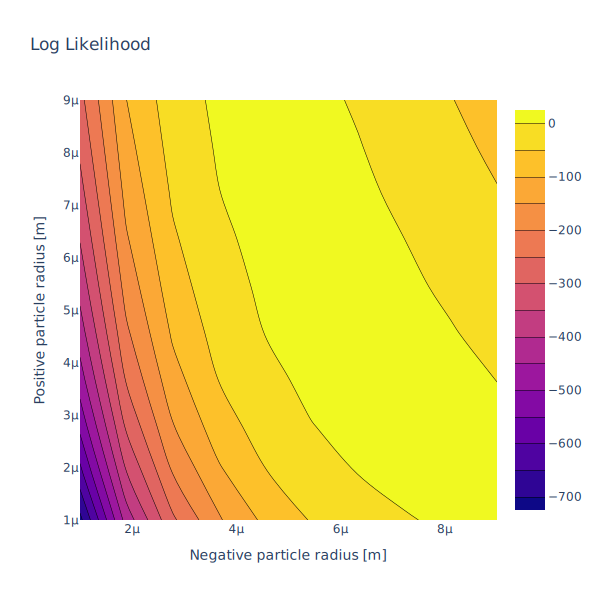

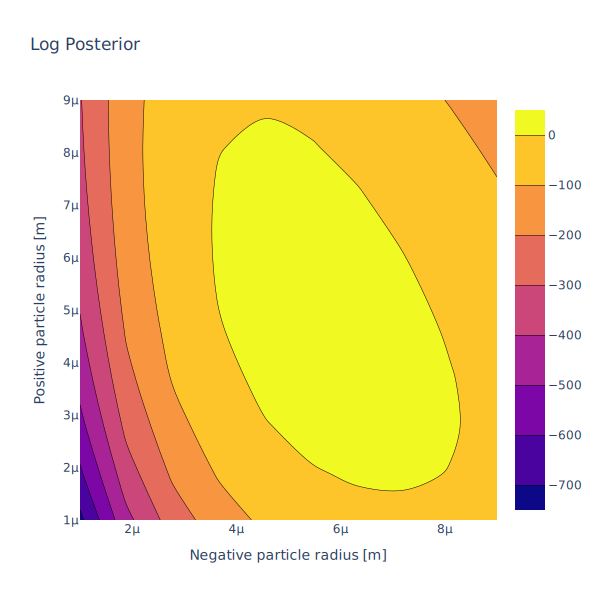

In [ ]:
steps = 10
bounds = np.asarray([[1e-6, 9e-6], [1e-6, 9e-6]])
pybop.plot2d(cost.prior, bounds=bounds, steps=steps, title="Log Prior")
pybop.plot2d(cost.likelihood, bounds=bounds, steps=steps, title="Log Likelihood")
pybop.plot2d(cost, bounds=bounds, steps=steps, title="Log Posterior");

Estimated Parameters: [5.51431513e-06 4.76290059e-06] in 10.675254821777344 seconds


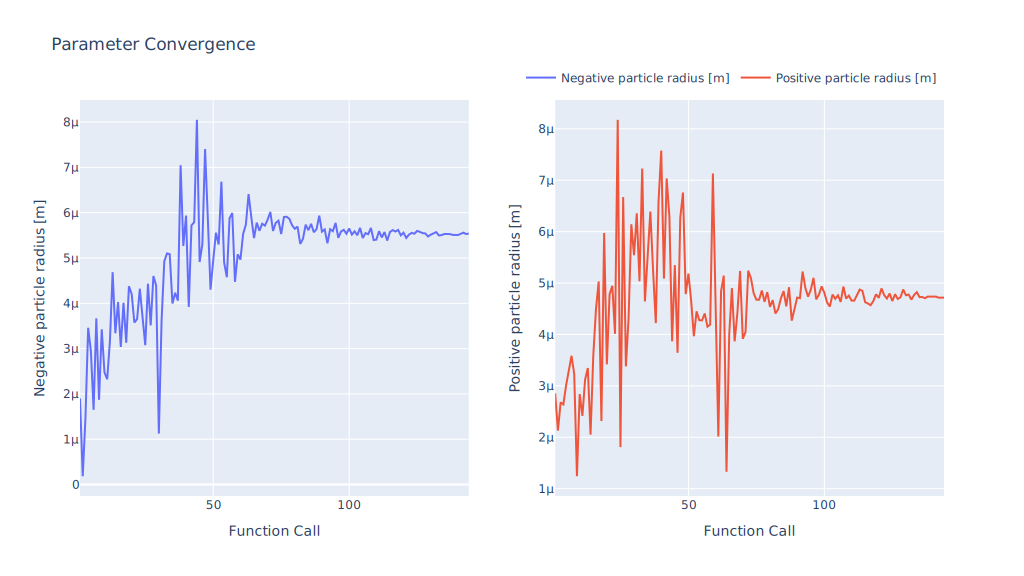

In [ ]:
optim = pybop.CMAES(cost, min_iterations=20, max_iterations=100, sigma0=1e-6)
start_time = time.time()
x, final_cost = optim.run()
print(f"Estimated Parameters: {x} in {time.time() - start_time} seconds")
pybop.plot_parameters(optim);

## Investigating the effect of number of observations on the Posterior

We've seen above that the proportional posterior can be represented from its components, the log-likelihood and log-prior. Next, to better understand when each of these terms can become dominating within the parameter inference problem we vary the number of measurement observations (i.e. the number of samples in the dataset) and inspect the construct posterior.

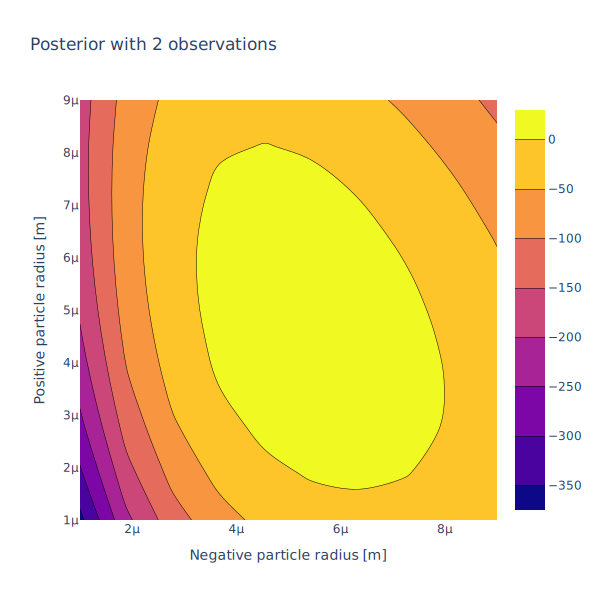

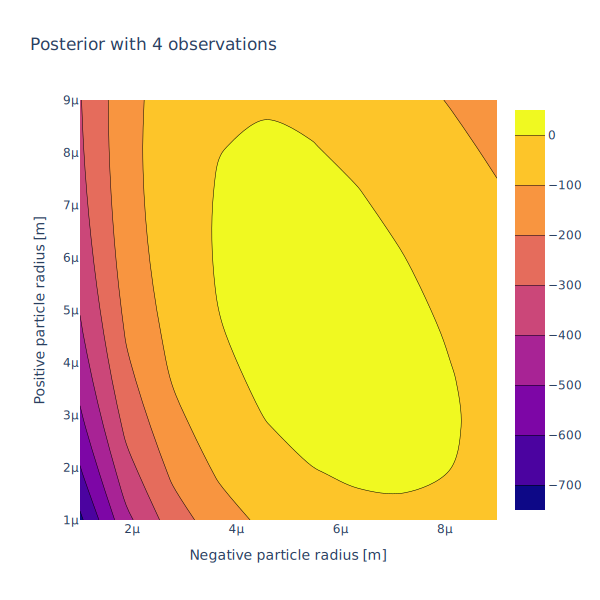

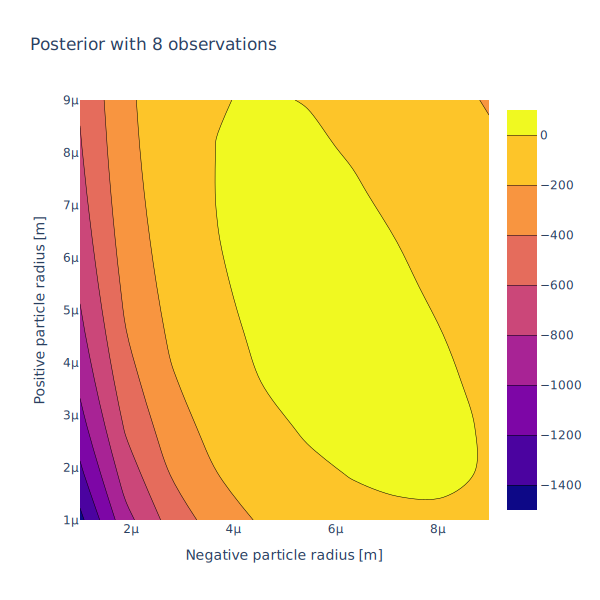

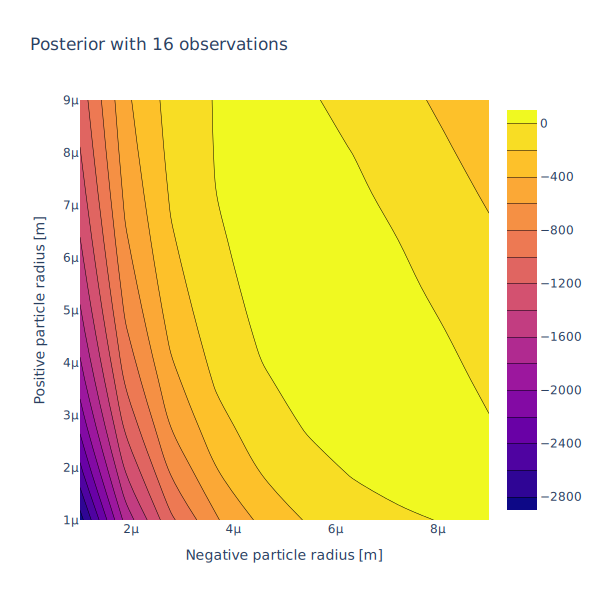

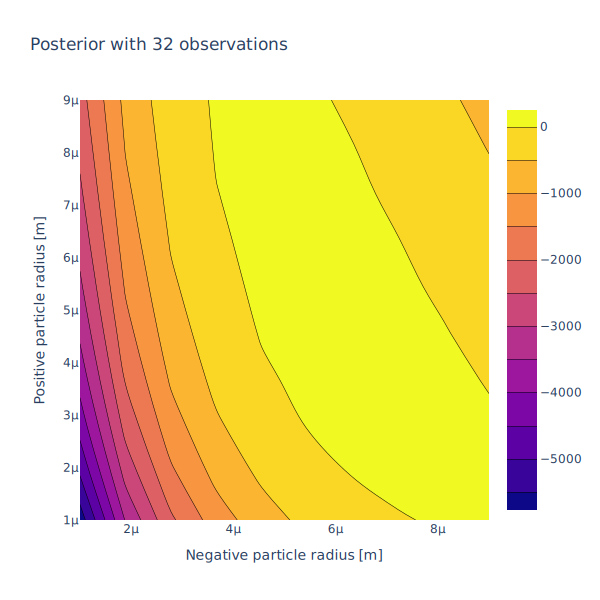

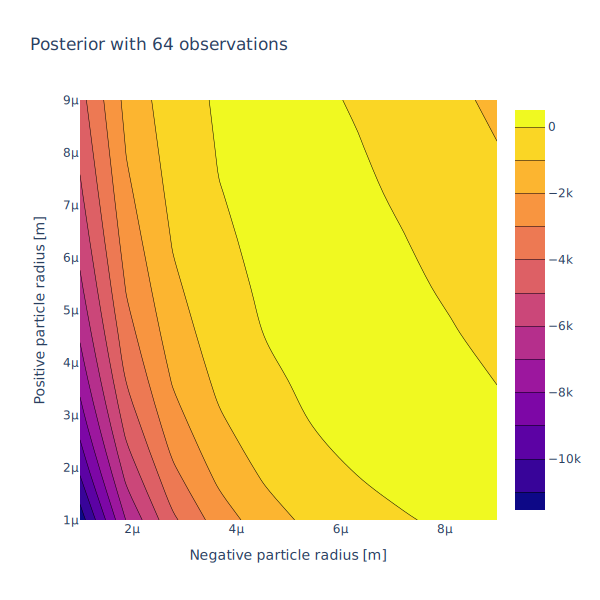

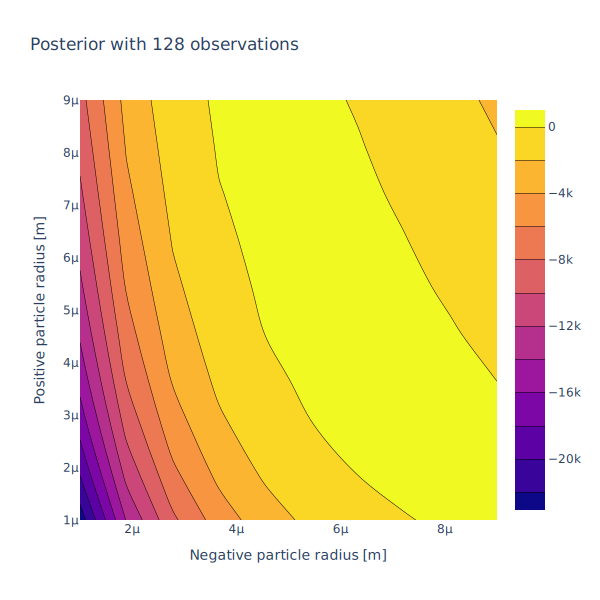

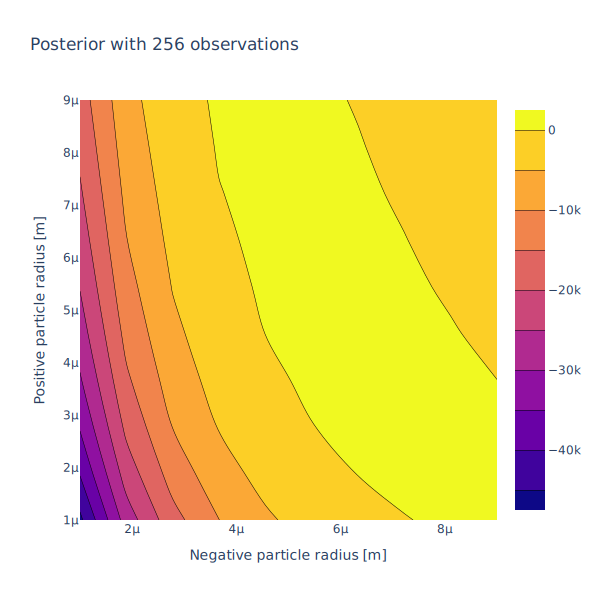

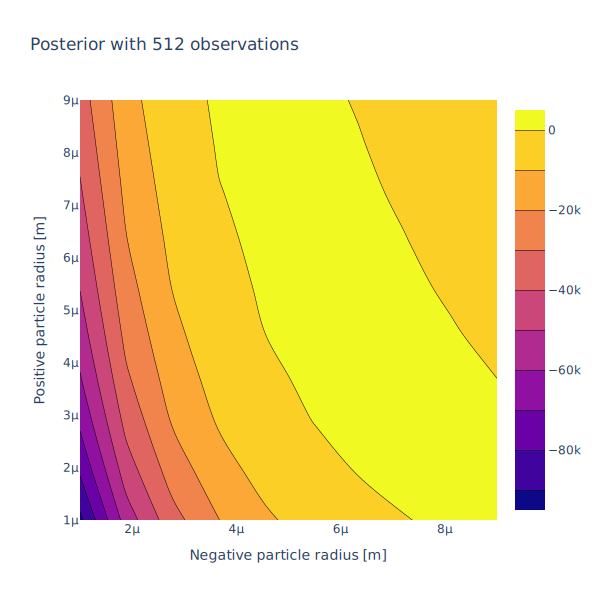

In [ ]:
for i, val in enumerate(values):
    dataset = pybop.Dataset(
        {
            "Time [s]": val["Time [s]"].data,
            "Current function [A]": val["Current [A]"].data,
            "Voltage [V]": val["Voltage [V]"].data
            + np.random.normal(0, sigma, len(val["Voltage [V]"].data)),
        }
    )
    # problem.set_target(dataset)
    problem = pybop.FittingProblem(model, parameters, dataset)
    likelihood = pybop.GaussianLogLikelihoodKnownSigma(problem, sigma0=0.005)
    cost = pybop.LogPosterior(likelihood, prior)
    pybop.plot2d(
        cost,
        bounds=bounds,
        steps=steps,
        title=f"Posterior with {observations[i]} observations",
    )

### Conclusion

This notebook illustrates how to perform parameter estimation using AdamW in PyBOP, providing insights into the optimisation process through various visualisations.